# Conversational bot for Madkudu support using RAG

RAG stands for Retrieval Augmented Generation, a technique where the capabilities of a large language model (LLM) are augmented by retrieving information from other systems and inserting them into the LLM’s context window via a prompt. 

It’s cheaper than fine tunning: fine-tuning models is expensive because the weights of the model parameters themselves must be adjusted. RAG is simply a series of vector/SQL queries and API calls, which cost tiny fractions of a cent.

1. Importing open ai key and the chat gpt model 

In [1]:
import os 
os.environ["OPENAI_API_KEY"] = ""

In [2]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    #chose a cheap model to save credits
    model = "gpt-3.5-turbo-0125",
    #the closer to 0, the more factual the results are going to be
    temperature = 0.4
)

In [3]:
llm.invoke("give me one synonym of phone")

AIMessage(content='telephone', response_metadata={'token_usage': {'completion_tokens': 1, 'prompt_tokens': 13, 'total_tokens': 14}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': 'fp_3bc1b5746c', 'finish_reason': 'stop', 'logprobs': None})

# 2. Loading the madkudu support data into the model

In [4]:
from langchain.document_loaders import DirectoryLoader
#using uft 8 since it has special characters
DATA_PATH = "madkudu_data"
loader = DirectoryLoader(DATA_PATH, glob="*.txt")
documents = loader.load()

Error loading file madkudu_data\-Enrichment.txt


ValueError: unstructured package not found, please install it with `pip install unstructured`

# 3. Splitting the data into chunks

In [12]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
#Alternative option
#text_splitter = CharacterTextSplitter(chunk_size=500, chunk_overlap=50)

text_splitter = RecursiveCharacterTextSplitter(
    #i chose 500 because the data is not that numerous
    # number of characters
    chunk_size = 500, 
    #How many chars are going to be overlapped in between each chunk
    chunk_overlap = 250,
    
    length_function = len,
    
    #includes index of character where the separation between each chunk is done
    add_start_index = True
    
    )

chunks = text_splitter.split_documents(documents)

In [13]:
len(chunks)

113

In [14]:
chunks[15].page_content

"Static enrichment: MadKudu partners with Clearbit, HG data, and PredictLeads to enrich your data. Are you already purchasing through ZoomInfo, Bombora, Datafox? No problem, MadKudu can also use this data. \nCRM information: actually any data from your CRM (Leads, Contacts, Accounts, Opportunities), be it provided by a 3rd party or from your Marketing and Sales input, can be pulled to MadKudu's platform."

# 4. Using hugging face to embed the chunks

In [15]:
from langchain.embeddings import HuggingFaceEmbeddings
# Define the path to the pre-trained model you want to use
modelPath = "sentence-transformers/all-MiniLM-l6-v2"

# Create a dictionary with model configuration options, specifying to use the CPU for computations
model_kwargs = {'device':'cpu'}

# Create a dictionary with encoding options, specifically setting 'normalize_embeddings' to False
encode_kwargs = {'normalize_embeddings': False}

# Initialize an instance of HuggingFaceEmbeddings with the specified parameters
embeddings = HuggingFaceEmbeddings(
    model_name=modelPath,     # Provide the pre-trained model's path
    model_kwargs=model_kwargs, # Pass the model configuration options
    encode_kwargs=encode_kwargs # Pass the encoding options
)

# 5. Store chunks in FAISS and embed them - Applying RAG

Here we are first creating our database with FAISS

RAG works better than fine-tuning the model because:

It’s cheaper: fine-tuning models is expensive because the weights of the model parameters themselves must be adjusted. RAG is simply a series of vector/SQL queries and API calls, which cost tiny fractions of a cent.

In [16]:
from langchain.vectorstores import FAISS

In [17]:
vectorstore = FAISS.from_documents(chunks, embeddings)

# 6. Create a simple chain (pipeline) for inferences

It allows you to process information in sequences. Could be use to create a a pipeline of 
- prompts
- models 
- memory buffers

Which makes it very powerful.

6.1 Create prompt and chain (with the LLM)

In [18]:
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_core.prompts import ChatPromptTemplate

template = """"Answer the following question based only on the provided context:

<context>
{context}
</context>

Question: {input}
"""
prompt = ChatPromptTemplate.from_template(template)
document_chain = create_stuff_documents_chain(llm, prompt)

6.2 Add the retriever to a chain

In [19]:

from langchain.chains import create_retrieval_chain

retriever = vectorstore.as_retriever()
retrieval_chain = create_retrieval_chain(retriever, document_chain)

In [20]:
response = retrieval_chain.invoke({
    "input": "what is likelyhood to buy"
})

response

{'input': 'what is likelyhood to buy',
 'context': [Document(page_content='Likelihood to Buy: refers to the output of a behavioral model predicting the level of engagement of a person or account. \nLift (Conversion lift): impact on conversion compared to the average population. \nA positive lift shows a positive impact on conversion of having this trait, or performing this action \nA negative life shows a negative impact on conversion of having this trait or performing this action', metadata={'source': 'all.txt', 'start_index': 25988}),
  Document(page_content='Likelihood to Buy: Looks at any interaction with your website, product, marketing team, sales team to identify patterns of your Leads and Accounts behaviors that lead to conversions. (What has this lead been doing recently?)\nLead Grade: Combines the Customer Fit and Likelihood to Buy into one score to help you simplify your workflows\nWe configure these models independently so if you’re not sure which ones are enabled in your a

# 6. Creating a memory chain - Adding conversational memory to our model

1. First we need to a new create a conversational retrieval chain

In [21]:
from langchain.chains import create_history_aware_retriever
from langchain_core.prompts import MessagesPlaceholder

prompt = ChatPromptTemplate.from_messages([
    
    MessagesPlaceholder(variable_name="chat_history"),
    ("user", "{input}"),
    ("user", "Given the above conversation, generate a search query to look up in order to get information relevant to the conversation")
])

retriever_chain = create_history_aware_retriever(llm, retriever, prompt)

Faking a conversation to create conversational memory

In [23]:
from langchain_core.messages import HumanMessage, AIMessage

chat_history = [
    HumanMessage(content="Can i found here what likelihood to buy is?"),
    AIMessage(content="Yes!")
]
answer = retriever_chain.invoke({
    "chat_history": chat_history,
    "input": "Tell me more about it!"
})

In [24]:
answer

[Document(page_content='Likelihood to Buy: refers to the output of a behavioral model predicting the level of engagement of a person or account. \nLift (Conversion lift): impact on conversion compared to the average population. \nA positive lift shows a positive impact on conversion of having this trait, or performing this action \nA negative life shows a negative impact on conversion of having this trait or performing this action', metadata={'source': 'all.txt', 'start_index': 25988}),
 Document(page_content='the Likelihood to Buy model (Behavioral)\nhelps answers "how are they using our product?", "what actions are most correlated to conversion?", "is now a good time to reach out?"\nThe third category of prediction models, the Lead Grade, is simply a combination of the two others.\nThe Customer Fit model (demographic)', metadata={'source': 'all.txt', 'start_index': 15612}),
 Document(page_content='Likelihood to Buy: Looks at any interaction with your website, product, marketing team,

# 6.2 Scaling the chain to store all the conversations with ** Document chain **
6.2.1 Add a document chain that will be able to store the history of the conversation in MessagePlaceholder objects


In [26]:
from langchain.chains import create_retrieval_chain

#prompt containing the past history
prompt = ChatPromptTemplate.from_messages(
    [
    ("system", "Answer the user's questions based on the below context:\n\n{context}"),
    # this is the variable that should be received where the conversation is going to be stored
    MessagesPlaceholder(variable_name="chat_history"),
    ("user", "{input}")
])

#this will store the conversation
document_chain = create_stuff_documents_chain(llm, prompt)



conversational_retrieval_chain = create_retrieval_chain(retriever_chain, document_chain)

6.2.2 Test it with a new history

In [32]:
chat_history = [
    HumanMessage(content="Can you tell me what likelihood to buy is?"),
    AIMessage(content="Likelihood to Buy: refers to the output of a behavioral model predicting the level of engagement of a person or account ")
]

response = conversational_retrieval_chain.invoke({
    'chat_history': chat_history,
    "input": "What model do you use"
})

In [33]:
response

{'chat_history': [HumanMessage(content='Can you tell me what likelihood to buy is?'),
  AIMessage(content='Likelihood to Buy: refers to the output of a behavioral model predicting the level of engagement of a person or account ')],
 'input': 'What mode! do you use',
 'context': [Document(page_content='the Likelihood to Buy model (Behavioral)\nhelps answers "how are they using our product?", "what actions are most correlated to conversion?", "is now a good time to reach out?"\nThe third category of prediction models, the Lead Grade, is simply a combination of the two others.\nThe Customer Fit model (demographic)', metadata={'source': 'all.txt', 'start_index': 15612}),
  Document(page_content='Likelihood to Buy: refers to the output of a behavioral model predicting the level of engagement of a person or account. \nLift (Conversion lift): impact on conversion compared to the average population. \nA positive lift shows a positive impact on conversion of having this trait, or performing thi

In [34]:
response["answer"]

'We use a Likelihood to Buy model, which is a behavioral model that predicts the level of engagement of a person or account.'

In [37]:
conversational_retrieval_chain.invoke({
    'chat_history': chat_history,
    "input": "how is it related to MQA?"
})

{'chat_history': [HumanMessage(content='Can you tell me what likelihood to buy is?'),
  AIMessage(content='Likelihood to Buy: refers to the output of a behavioral model predicting the level of engagement of a person or account ')],
 'input': 'how is it related to MQA?',
 'context': [Document(page_content='Likelihood to Buy: refers to the output of a behavioral model predicting the level of engagement of a person or account. \nLift (Conversion lift): impact on conversion compared to the average population. \nA positive lift shows a positive impact on conversion of having this trait, or performing this action \nA negative life shows a negative impact on conversion of having this trait or performing this action', metadata={'source': 'all.txt', 'start_index': 25988}),
  Document(page_content='the Likelihood to Buy model (Behavioral)\nhelps answers "how are they using our product?", "what actions are most correlated to conversion?", "is now a good time to reach out?"\nThe third category of 

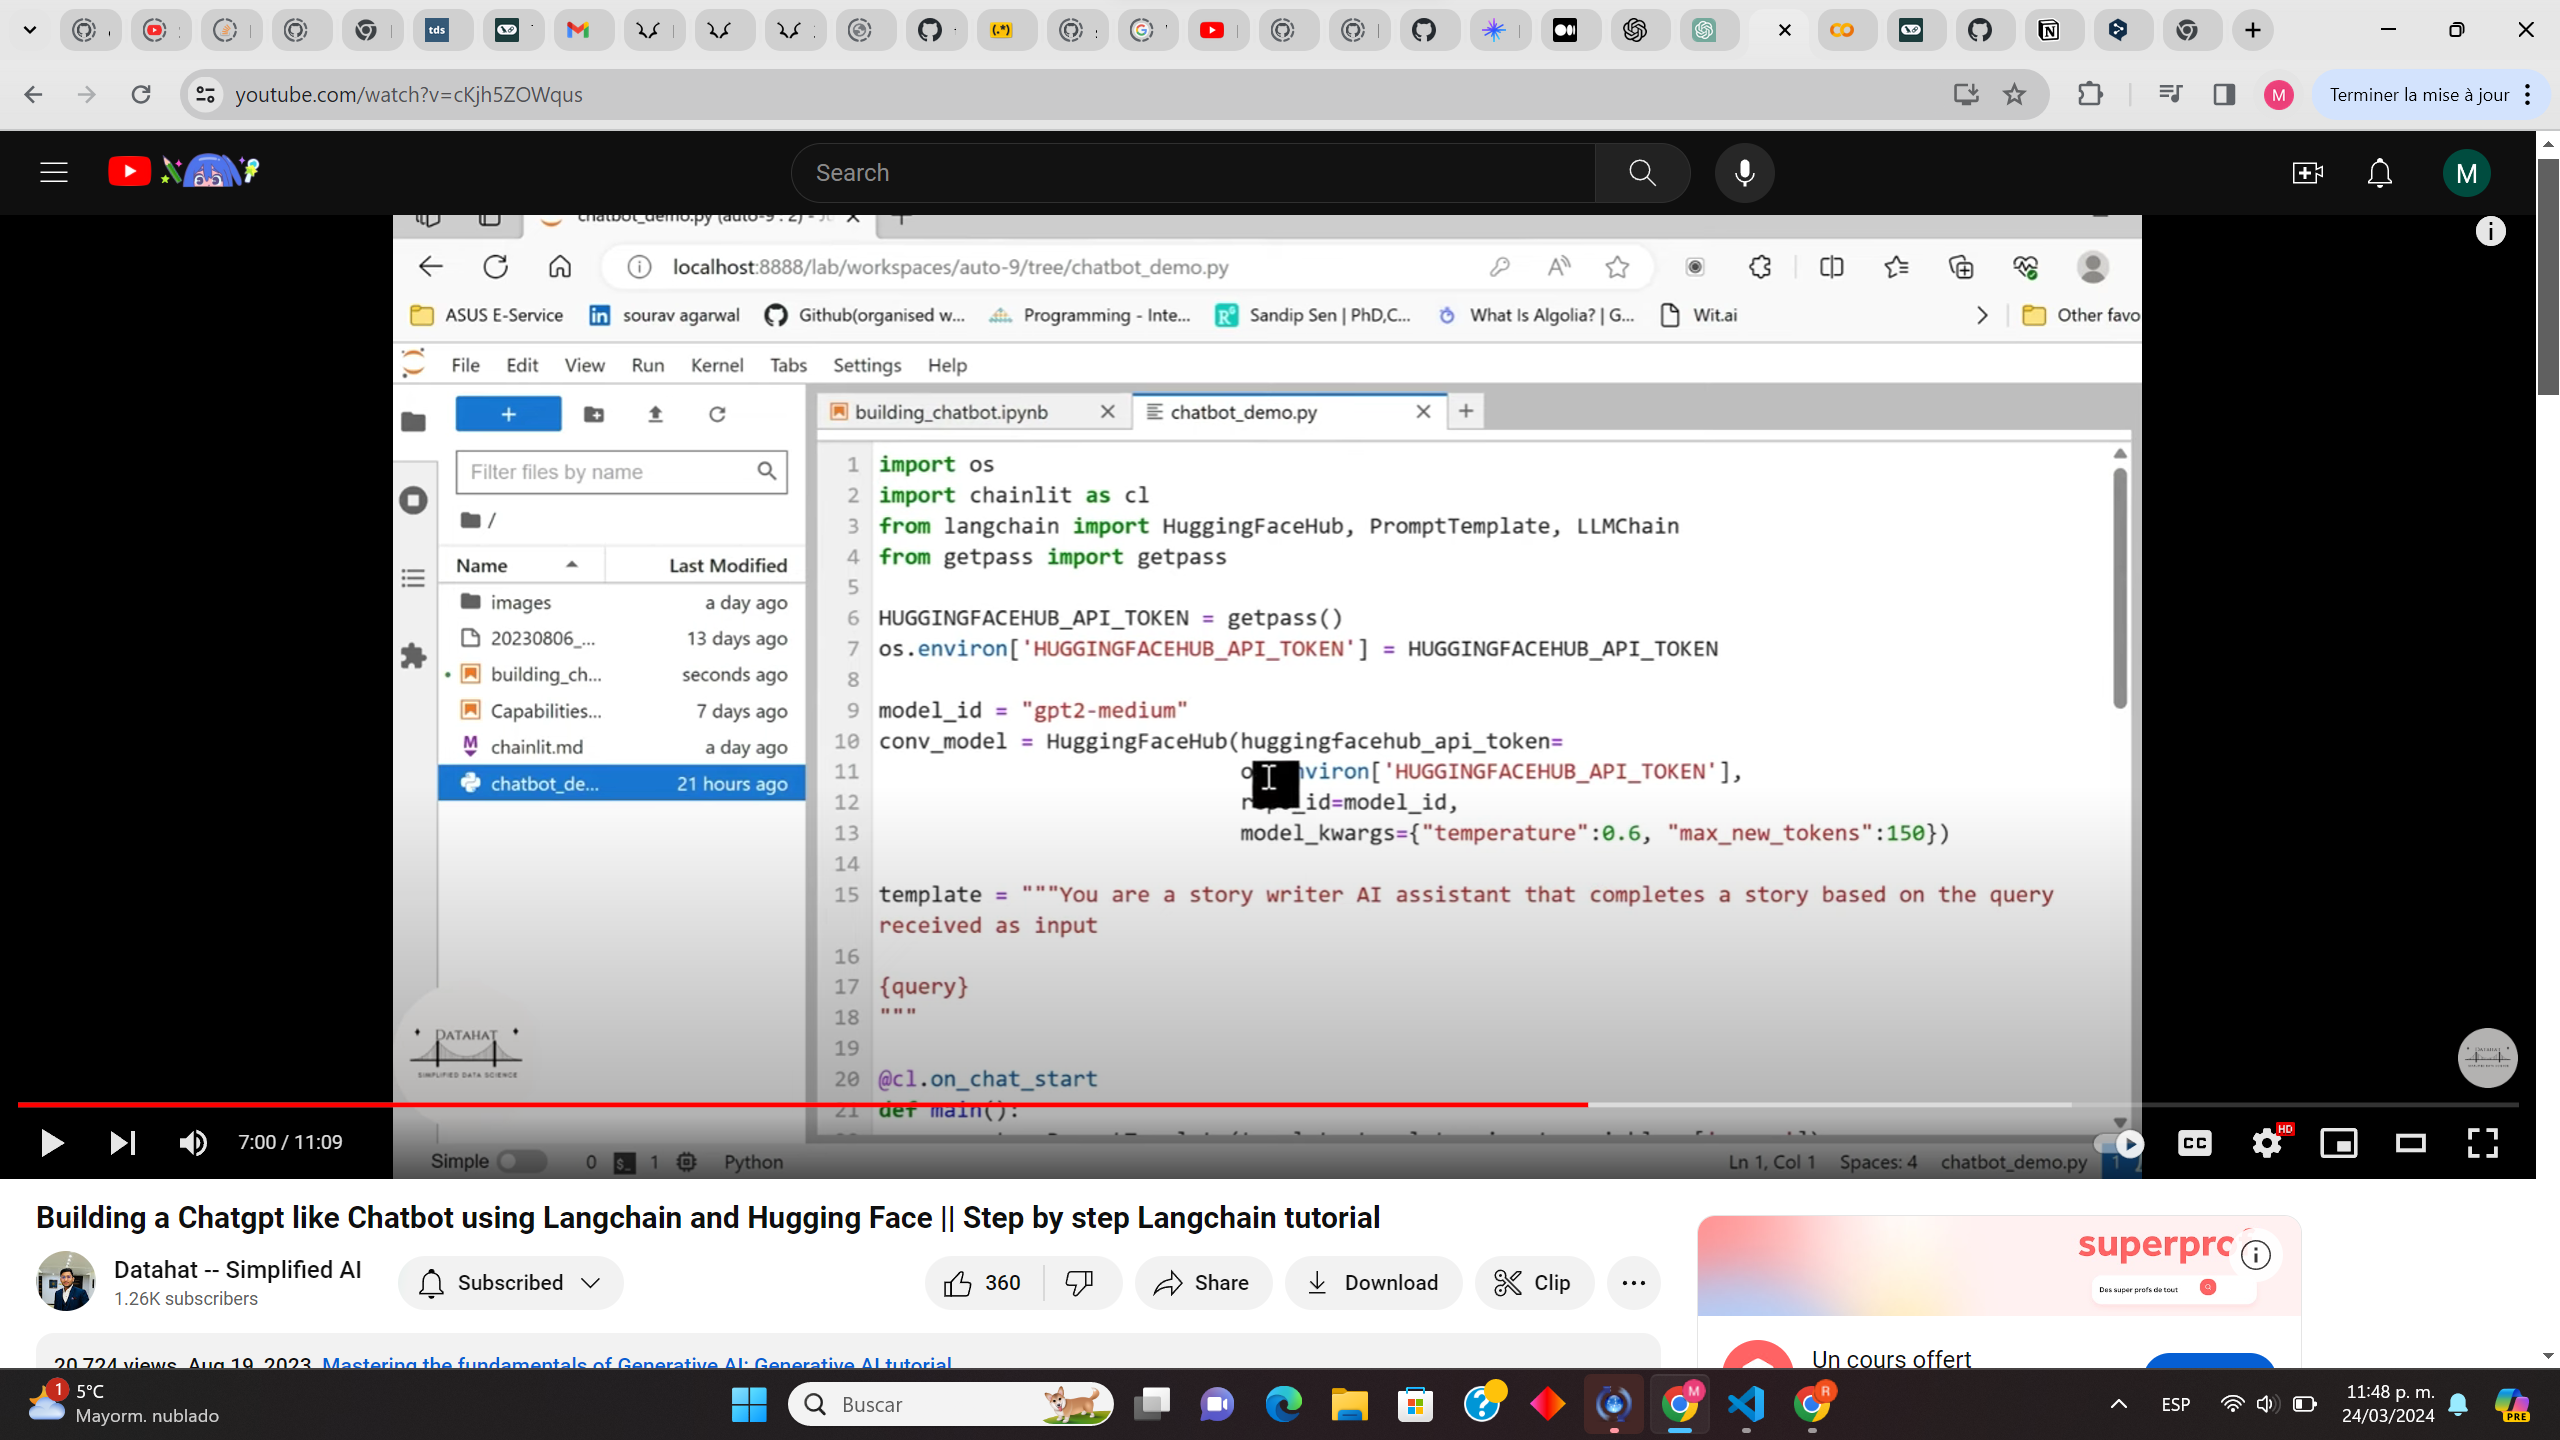

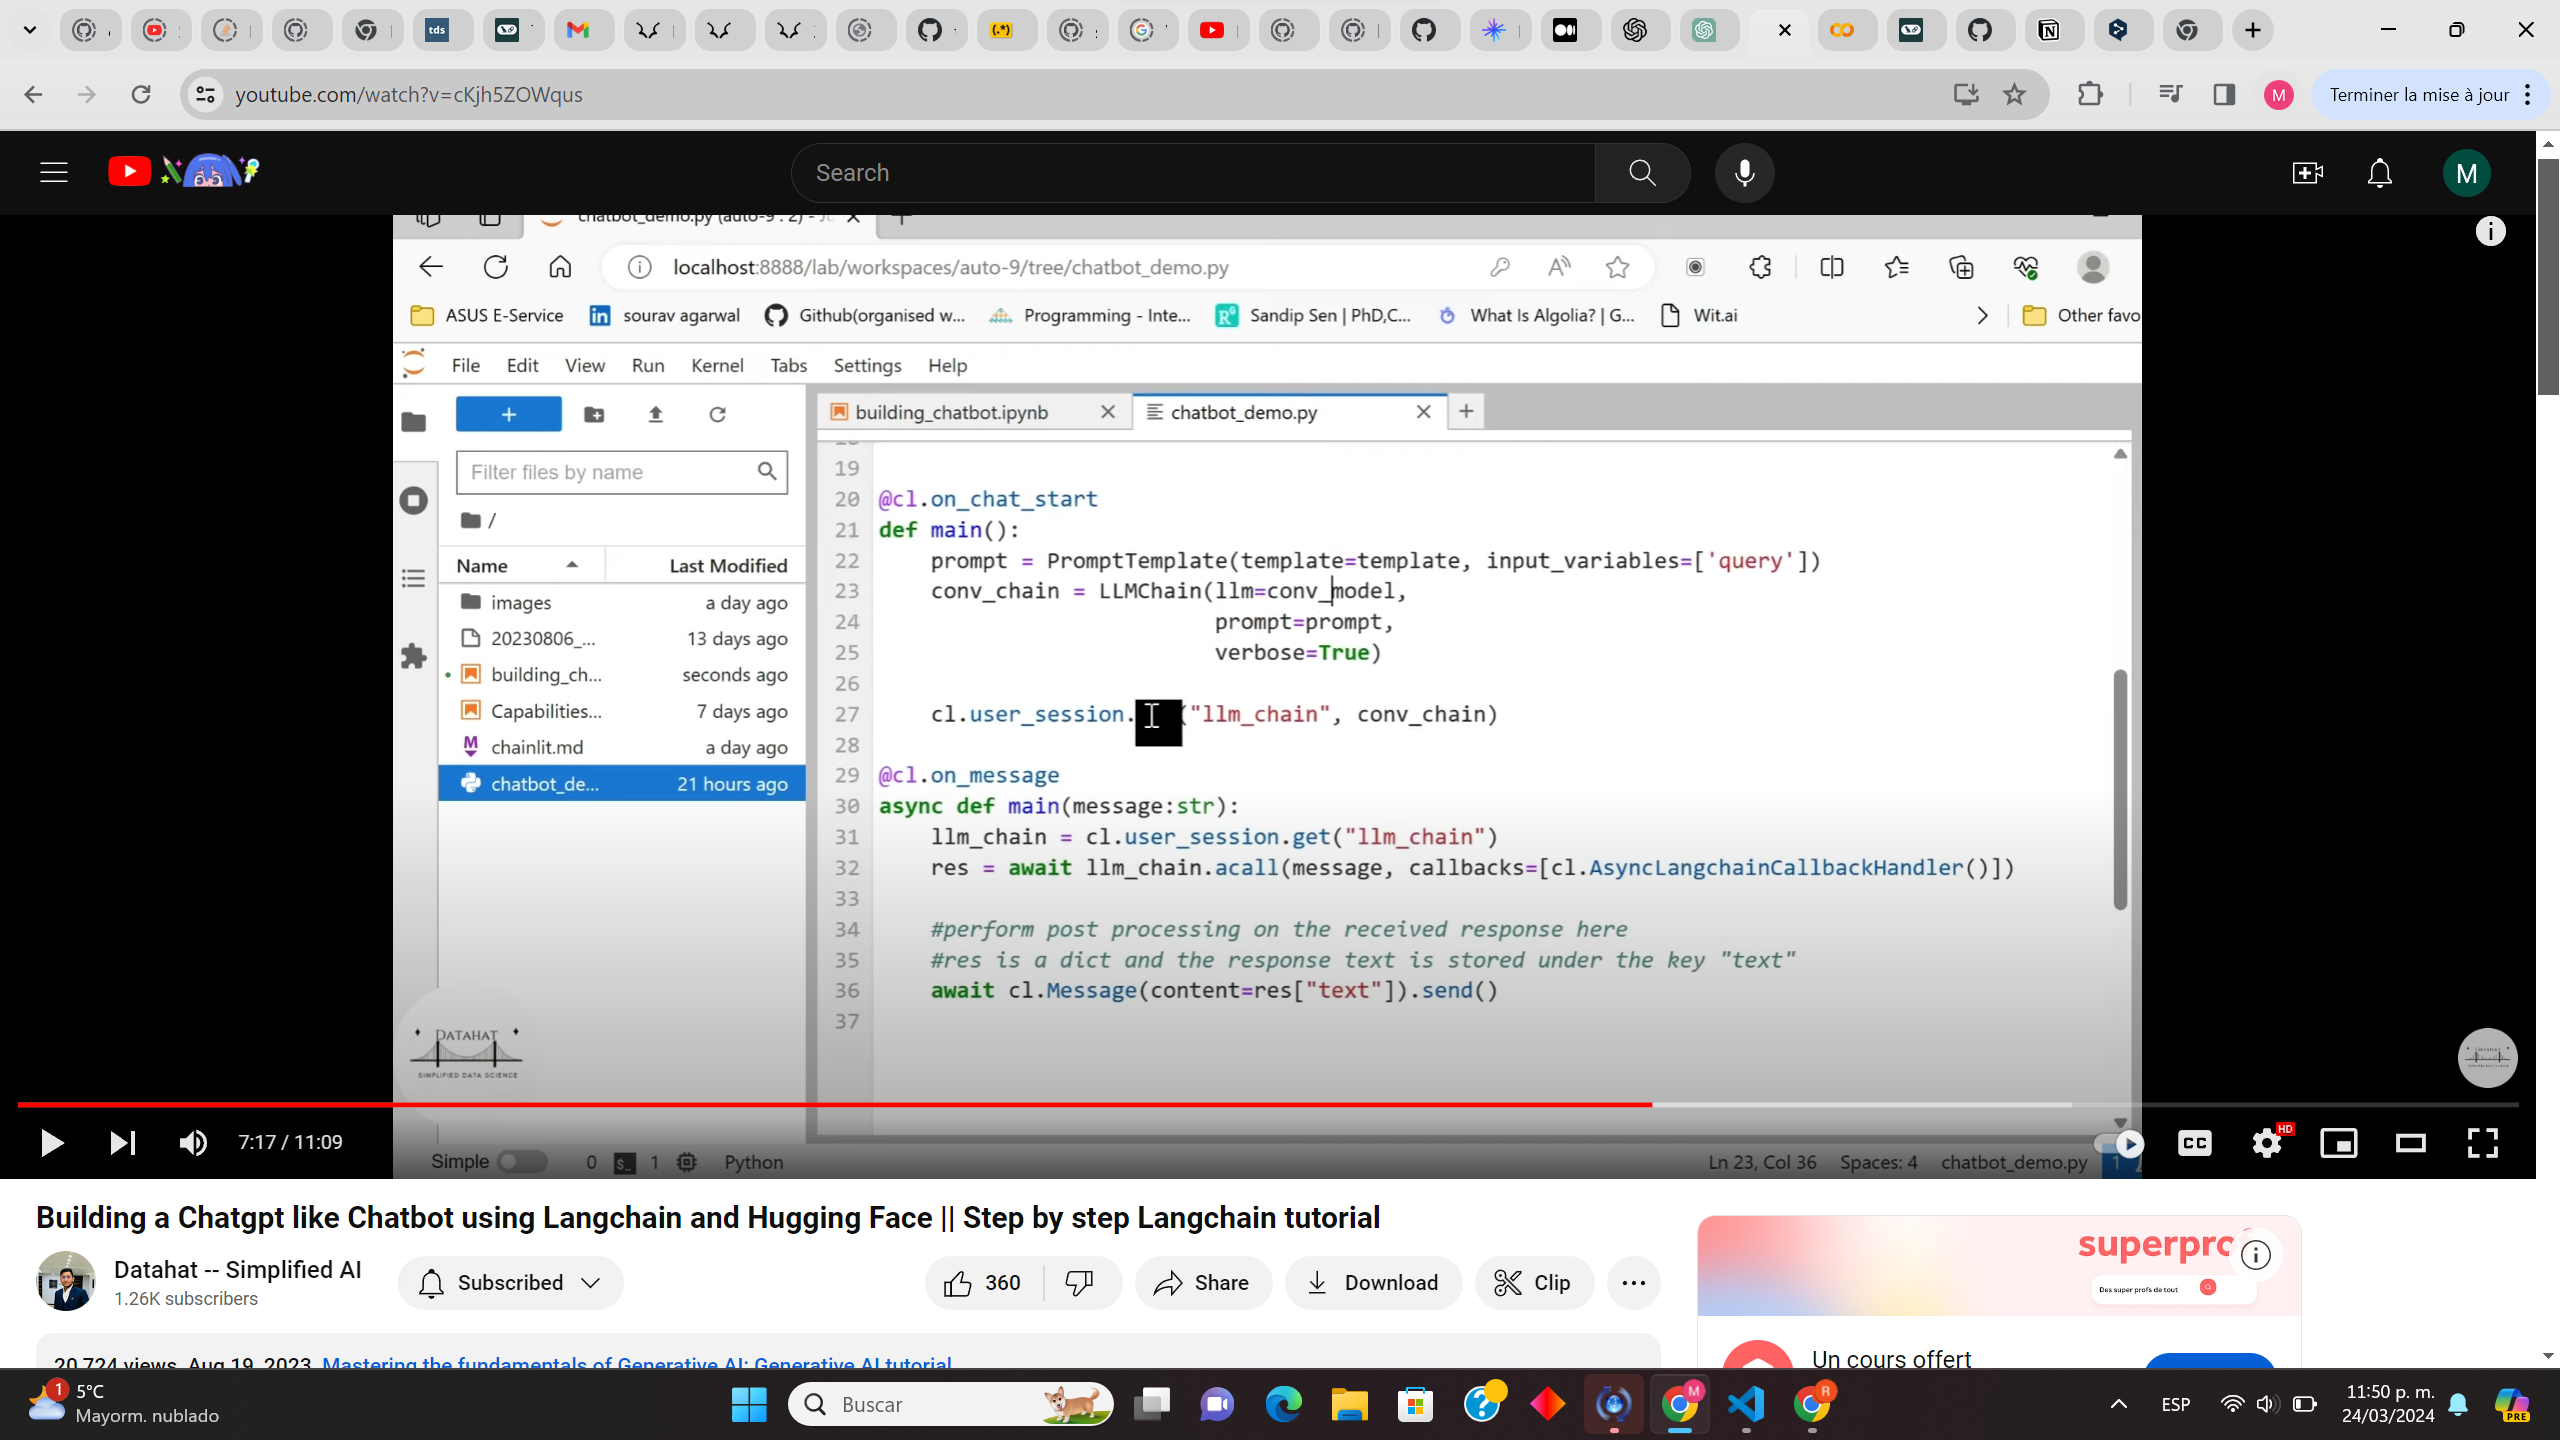

In [40]:
import chainlit as cl